# 3. Regression
In this notebook we will finally run our regression models. For that purpose, we are importing the necessary libraries and functions from our ```modules``` folder. We are also importing our extracted dataframe

In [1]:
# Warnings
import warnings
warnings.filterwarnings("ignore")

# Basic Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
import seaborn as sns
from scipy import stats
from functools import reduce

# Statsmodels
import statsmodels.api as sm
import pmdarima as pmd
from pmdarima.arima import auto_arima
from statsmodels.tsa.api import VAR
from statsmodels.tsa.vector_ar.var_model import VARResults
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

# Machine Learning models
import sklearn.model_selection as skm
import sklearn.linear_model as skl
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.linear_model import Ridge, Lasso, ElasticNet, ElasticNetCV, LinearRegression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    mean_absolute_percentage_error,
    median_absolute_error,
    r2_score,
    precision_score

)

from xgboost import XGBRegressor



In [2]:
# We import our own functions
import sys
sys.path.append('../../..')  # Move two levels up to the project root
from modules.functions import *

In [3]:
df = pd.read_csv('../../../input/df_raw_c23.csv', parse_dates=['Fecha'], index_col='Fecha')
df.tail()

,CPI Core,CPI Tradable,CPI Non-Tradable,CPI,CPI Non-Core,CPI Food and Energy,CPI Excluding Food and Energy,CPI Food and Beverages,CPI Excluding Food and Beverages,CPI Core Excluding Food and Beverages,CPI Imported,Wholesale Price Index,Reserve Requirement Rate,Monetary Policy Rate,Circulating Currency Seasonally Adjusted (mill S/),Net International Reserves (mill $),Real Minimum Wage (Index)
Fecha,,,,,,,,,,,,,,,,,
2023-08-01,0.308731,0.263821,0.147377,0.182324,-0.071459,0.175741,0.189515,0.263738,0.125240,0.215058,-0.170008,-0.104763,5.137951,7.75,-0.002584,-0.019404,-0.003747
2023-09-01,0.281829,0.237390,0.089467,0.133933,-0.163217,0.099223,0.165369,0.179682,0.102272,0.195769,-0.206148,-0.125837,5.269584,7.50,0.002271,-0.008615,-0.000164
2023-10-01,0.254555,0.210974,0.031289,0.085365,-0.254697,0.022078,0.141472,0.094521,0.079821,0.176261,-0.240150,-0.144366,5.277209,7.25,0.006684,-0.001206,0.003235
2023-11-01,0.226933,0.184472,-0.026935,0.036736,-0.345597,-0.055512,0.117886,0.008508,0.057913,0.156596,-0.272242,-0.160344,5.625714,7.00,-0.002776,0.008482,0.001633
2023-12-01,0.198984,0.157822,-0.085018,-0.011845,-0.435639,-0.133358,0.094639,-0.078087,0.036539,0.136819,-0.302719,-0.173843,5.857378,6.75,-0.013468,-0.010011,-0.003992


In [4]:
df_lags = pd.read_csv('../../../input/df_lags_c23.csv', parse_dates=['Fecha'], index_col='Fecha')
df_lags.tail()

,CPI Core,CPI Tradable_lag_1,CPI Tradable_lag_2,CPI Non-Tradable_lag_1,CPI Non-Tradable_lag_2,CPI_lag_1,CPI_lag_2,CPI Non-Core_lag_1,CPI Non-Core_lag_2,CPI Food and Energy_lag_1,...,Reserve Requirement Rate_lag_1,Reserve Requirement Rate_lag_2,Monetary Policy Rate_lag_1,Monetary Policy Rate_lag_2,Circulating Currency Seasonally Adjusted (mill S/)_lag_1,Circulating Currency Seasonally Adjusted (mill S/)_lag_2,Net International Reserves (mill $)_lag_1,Net International Reserves (mill $)_lag_2,Real Minimum Wage (Index)_lag_1,Real Minimum Wage (Index)_lag_2
Fecha,,,,,,,,,,,,,,,,,,,,,
2023-08-01,0.308731,0.290249,0.316561,0.204813,0.261591,0.230389,0.277964,0.020204,0.111347,0.251427,...,5.617809,5.985237,7.75,7.75,-0.017678,-0.011038,0.004548,-0.043297,-0.003909,0.001566
2023-09-01,0.281829,0.263821,0.290249,0.147377,0.204813,0.182324,0.230389,-0.071459,0.020204,0.175741,...,5.137951,5.617809,7.75,7.75,-0.002584,-0.017678,-0.019404,0.004548,-0.003747,-0.003909
2023-10-01,0.254555,0.237390,0.263821,0.089467,0.147377,0.133933,0.182324,-0.163217,-0.071459,0.099223,...,5.269584,5.137951,7.50,7.75,0.002271,-0.002584,-0.008615,-0.019404,-0.000164,-0.003747
2023-11-01,0.226933,0.210974,0.237390,0.031289,0.089467,0.085365,0.133933,-0.254697,-0.163217,0.022078,...,5.277209,5.269584,7.25,7.50,0.006684,0.002271,-0.001206,-0.008615,0.003235,-0.000164
2023-12-01,0.198984,0.184472,0.210974,-0.026935,0.031289,0.036736,0.085365,-0.345597,-0.254697,-0.055512,...,5.625714,5.277209,7.00,7.25,-0.002776,0.006684,0.008482,-0.001206,0.001633,0.003235


## 3.1 Benchmark models

In the first section, we first run our benchmark econometric models: ```Random Walk (RW)```,  ```Autoregressive Integrated Moving Average (ARIMA)``` and ```Vector Autoregression (VAR)``` processes

### 3.1.1 Random Walk (RW)

In [5]:
forecast_horizons = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

# We define our target variable
target = 'CPI Core'

# We only use CPI as Random Walk is an univariate process
df_CPI_Core = pd.DataFrame(df_lags['CPI Core'])

# We create our train and test set
train_set = df_CPI_Core[df_CPI_Core.index < '2023-01-01']
test_set  = df_CPI_Core[df_CPI_Core.index >= '2023-01-01']

predictions = {}

for h in forecast_horizons:
    # We get the values h horizons before
    predicted_value = train_set.iloc[-1, 0] 

    # We save it for horizon h
    predictions[h] = predicted_value

predicted = pd.DataFrame([predictions]).transpose().reset_index()

predicted.columns = ['Horizon', 'Prediction']

predicted = predicted.set_index(test_set.index)

predicted

,Horizon,Prediction
Fecha,,
2023-01-01,1,0.503978
2023-02-01,2,0.503978
2023-03-01,3,0.503978
2023-04-01,4,0.503978
2023-05-01,5,0.503978
2023-06-01,6,0.503978
2023-07-01,7,0.503978
2023-08-01,8,0.503978
2023-09-01,9,0.503978


In [6]:
# We create our results dataframe, concatenating the predicted and the actual values
results = pd.concat([predicted, test_set[target]], axis=1)
results.rename(columns={'Horizon': 'Horizon', 'Prediction': 'Predicted', 'CPI Core': 'Actual'}, inplace=True)
results

,Horizon,Predicted,Actual
Fecha,,,
2023-01-01,1,0.503978,0.486151
2023-02-01,2,0.503978,0.461812
2023-03-01,3,0.503978,0.436986
2023-04-01,4,0.503978,0.412057
2023-05-01,5,0.503978,0.386863
2023-06-01,6,0.503978,0.361269
2023-07-01,7,0.503978,0.335223
2023-08-01,8,0.503978,0.308731
2023-09-01,9,0.503978,0.281829


In [7]:
# We get our metrics using our function
RMSE_rw, MAPE_rw = get_metrics(results, 'RW')
metrics_rw = pd.concat([RMSE_rw, MAPE_rw], axis = 1)
metrics_rw

,RMSE_RW,MAPE_RW
1,0.017827,0.036670
2,0.032371,0.063988
3,0.046846,0.093760
4,0.061305,0.126089
5,0.075827,0.161417
6,0.090475,0.200351
7,0.105284,0.243646
8,0.120268,0.292242
9,0.135427,0.347353
10,0.150757,0.410601


### 3.1.2 Autoregressive Integrated Moving Average (ARIMA)

In [8]:
# We only use CPI as ARIMA is an univariate process
df_CPI_Core = pd.DataFrame(df_lags['CPI Core'])

# We create our train and test set
train_set = df_CPI_Core[df_CPI_Core.index < '2023-01-01']
test_set  = df_CPI_Core[df_CPI_Core.index >= '2023-01-01']

In [9]:
# We find the best SARIMA model
autoarima = pmd.auto_arima(
        y = train_set,
        start_p=1,
        start_q=0,
        seasonal=True,
        max_p=12,
        max_d=1,
        max_q=6,
        max_P=12,
        max_D=1,
        max_Q=6,
        m=4,
        n_jobs=-1,
        suppress_warnings=True,
        )

# We indicate the seasonal order for monthly data
seasonal_order = (1, 1, 1, 12)

# We create our ARIMA model
model = SARIMAX(train_set,
                order=autoarima.order,
                seasonal_order=autoarima.seasonal_order,
                enforce_stationarity = False,
                enforce_invertibility = False)
        
# We fit the model
model_fit = model.fit()

# We forecast for the next 12 horizons
forecast_values = model_fit.get_forecast(steps=12)
predicted = pd.DataFrame(forecast_values.predicted_mean, index = test_set.index)

# We create our results dataframe, concatenating the predicted and the actual values
results = pd.concat([predicted, test_set[target]], axis=1)
results.rename(columns={'predicted_mean': 'Predicted', 'CPI Core': 'Actual'}, inplace=True)
results

,Predicted,Actual
Fecha,,
2023-01-01,0.485767,0.486151
2023-02-01,0.464391,0.461812
2023-03-01,0.440750,0.436986
2023-04-01,0.415739,0.412057
2023-05-01,0.390209,0.386863
2023-06-01,0.364943,0.361269
2023-07-01,0.340645,0.335223
2023-08-01,0.317922,0.308731
2023-09-01,0.297279,0.281829


In [10]:
# We get our metrics using our function
RMSE_arima, MAPE_arima = get_metrics(results, 'ARIMA')
metrics_arima= pd.concat([RMSE_arima, MAPE_arima], axis = 1)
metrics_arima

,RMSE_ARIMA,MAPE_ARIMA
1,0.000384,0.000790
2,0.001844,0.003188
3,0.002644,0.004996
4,0.002938,0.005981
5,0.003024,0.006515
6,0.003142,0.007124
7,0.003558,0.008417
8,0.004652,0.011087
9,0.006764,0.015946
10,0.010074,0.023999


### 3.1.3 Vector autoregression (VAR)

In [11]:
# We define our target variable, as well as our train and test set
target = 'CPI Core'
train_set = df[df.index < '2023-01-01']
test_set  = df[df.index >= '2023-01-01']

In [12]:
# We model our VAR including up to two lags
model_var = VAR(df)
model_fit = model_var.fit(2)

In [13]:
# We forecast for the next 12 months
preds = model_fit.forecast(df.values[-2:], 12)
preds = pd.DataFrame(preds, index = test_set[target].index)[0]

# We create our results dataframe, concatenating the predicted and the actual values
results = pd.concat([preds, test_set[target]],axis=1)
results.rename(columns={'CPI Core': 'Actual', 0: 'Predicted'}, inplace=True)
results

,Predicted,Actual
Fecha,,
2023-01-01,0.171810,0.486151
2023-02-01,0.145297,0.461812
2023-03-01,0.119276,0.436986
2023-04-01,0.093736,0.412057
2023-05-01,0.068729,0.386863
2023-06-01,0.044346,0.361269
2023-07-01,0.020718,0.335223
2023-08-01,-0.001989,0.308731
2023-09-01,-0.023584,0.281829


In [14]:
# We get our metrics using our function
RMSE_var, MAPE_var = get_metrics(results, 'VAR')
metrics_var= pd.concat([RMSE_var, MAPE_var], axis = 1)
metrics_var

,RMSE_VAR,MAPE_VAR
1,0.314340,0.646591
2,0.315429,0.665983
3,0.316192,0.686338
4,0.316725,0.707883
5,0.317008,0.730775
6,0.316993,0.755188
7,0.316639,0.781332
8,0.315905,0.809470
9,0.314757,0.839938
10,0.313161,0.873173


<Axes: >

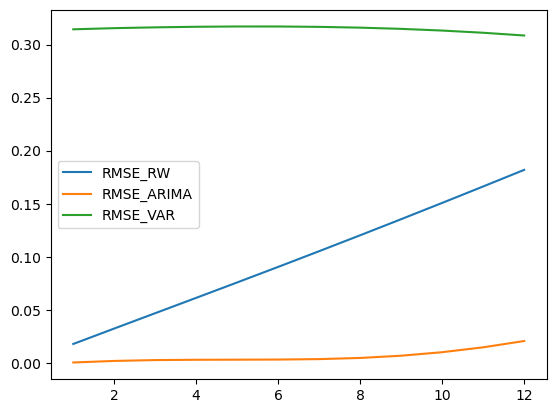

In [15]:
rmse_econometrics = pd.concat([RMSE_rw, RMSE_arima, RMSE_var], axis=1)

rmse_econometrics.plot()

## 3.2 Machine learning models

In the second section, we run our machine learning models: ```Ridge Regression (Ridge)```,  ```Least Absolute Shrinkage and Selection Operator (LASSO)``` and ```Random Forest (RF)``` models

### 3.2.1 Ridge Regression (Ridge)

In [16]:
target = "CPI Core"
Y = pd.DataFrame(df_lags[target])
X = df_lags.drop(columns=[target])

y_train = train_set[target]
y_test  = test_set[target]
X_train = train_set.loc[:, train_set.columns != target]
X_test  = test_set.loc[:, test_set.columns != target]

# Implementing the temporal cross-validation
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5, test_size= 12)

# We implement the model
import sklearn.linear_model as skl
ridge = skl.ElasticNet(l1_ratio=0)
model = ridge

# We define out lambdas and implement our gridparams
lambdas    = np.linspace(0.0001, 1, 1000)

grid_params = {'alpha': lambdas}

# We implement our gridsearch
grid_search = GridSearchCV( model, grid_params, cv = tscv, scoring = 'neg_mean_squared_error')

grid_search.fit( X_train, y_train )

pd.DataFrame( grid_search.cv_results_ )

# And select out best model
best_model  = grid_search.best_estimator_
best_params = grid_search.best_params_

In [17]:
pred_vars = X_train.columns.to_list()
coefficients = best_model.coef_
vars_df_ridge      = pd.DataFrame( {'Var': best_model.feature_names_in_, 'Coefficient': coefficients } )
vars_df_ridge      = vars_df_ridge.reindex( vars_df_ridge[ 'Coefficient' ].abs().sort_values( ascending = False ).index )
vars_df_ridge.to_excel( f'../../../output/3_Regression/c23/c23coef_ridge.xlsx' )

In [18]:
# We use the best model to predict
y_pred = best_model.predict( X_test )
y_pred = pd.Series(y_pred, index = y_test.index)
print(y_pred)

Fecha
2023-01-01    0.494015
2023-02-01    0.471677
2023-03-01    0.447559
2023-04-01    0.425671
2023-05-01    0.402124
2023-06-01    0.375888
2023-07-01    0.353025
2023-08-01    0.327963
2023-09-01    0.303482
2023-10-01    0.278525
2023-11-01    0.252957
2023-12-01    0.226161
dtype: float64


In [19]:
# And concatenate the results
results = pd.concat([y_pred, y_test],axis=1)
results.rename(columns={'CPI Core': 'Actual', 0: 'Predicted'}, inplace=True)
results

,Predicted,Actual
Fecha,,
2023-01-01,0.494015,0.486151
2023-02-01,0.471677,0.461812
2023-03-01,0.447559,0.436986
2023-04-01,0.425671,0.412057
2023-05-01,0.402124,0.386863
2023-06-01,0.375888,0.361269
2023-07-01,0.353025,0.335223
2023-08-01,0.327963,0.308731
2023-09-01,0.303482,0.281829


In [20]:
RMSE_ridge, MAPE_ridge = get_metrics(results, 'Ridge')

<Axes: >

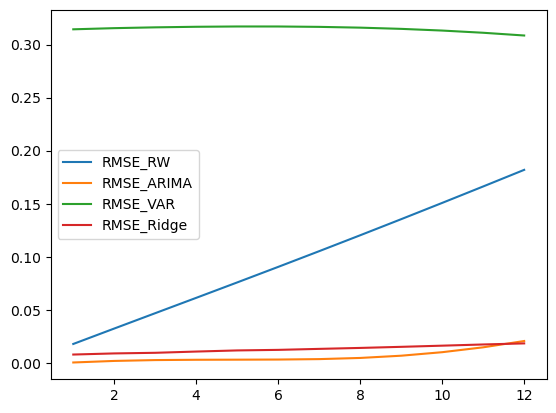

In [21]:
pd.concat([RMSE_rw, RMSE_arima, RMSE_var, RMSE_ridge], axis=1).plot()

### 3.2.2 Lasso Regression (Lasso)

In [22]:
target = "CPI Core"
Y = pd.DataFrame(df_lags[target])
X = df_lags.drop(columns=[target])

y_train = train_set[target]
y_test  = test_set[target]
X_train = train_set.loc[:, train_set.columns != target]
X_test  = test_set.loc[:, test_set.columns != target]

# We define the model
import sklearn.linear_model as skl
lasso = skl.ElasticNet( l1_ratio=1, random_state = 2024 )
model = lasso

# We define out lambdas and implement our gridparams
lambdas    = np.linspace(0.0001, 1, 1000)
grid_params = {'alpha': lambdas}

# We implement the gridsearch
grid_search = GridSearchCV( model, grid_params, cv = tscv, scoring = 'neg_mean_squared_error')
grid_search.fit( X_train, y_train )
pd.DataFrame( grid_search.cv_results_ )

best_model  = grid_search.best_estimator_
best_params = grid_search.best_params_

In [23]:
pred_vars = X_train.columns.to_list()
coefficients = best_model.coef_
vars_df_lasso      = pd.DataFrame( {'Var': best_model.feature_names_in_, 'Coefficient': coefficients } )
vars_df_lasso      = vars_df_lasso.reindex( vars_df_lasso[ 'Coefficient' ].abs().sort_values( ascending = False ).index )
vars_df_lasso.to_excel( f'../../../output/3_Regression/c23/c23coef_lasso.xlsx' )

In [24]:
y_pred = best_model.predict( X_test )
y_pred = pd.Series(y_pred, index = y_test.index)

In [25]:
results = pd.concat([y_pred, y_test],axis=1)
results.rename(columns={'CPI Core': 'Actual', 0: 'Predicted'}, inplace=True)
results

,Predicted,Actual
Fecha,,
2023-01-01,0.491330,0.486151
2023-02-01,0.467621,0.461812
2023-03-01,0.444025,0.436986
2023-04-01,0.419267,0.412057
2023-05-01,0.394635,0.386863
2023-06-01,0.369935,0.361269
2023-07-01,0.344361,0.335223
2023-08-01,0.318350,0.308731
2023-09-01,0.292206,0.281829


In [26]:
RMSE_lasso, MAPE_lasso = get_metrics(results, 'Lasso')

<Axes: >

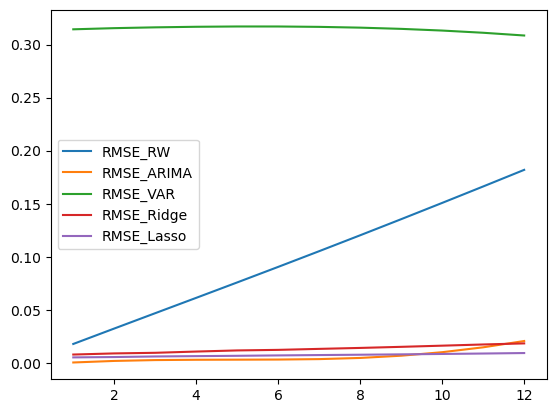

In [27]:
pd.concat([RMSE_rw, RMSE_arima, RMSE_var, RMSE_ridge, RMSE_lasso], axis=1).plot()

### 3.2.3 Random Forest Regression (Random Forest)

In [28]:
target = "CPI Core"
Y = pd.DataFrame(df_lags[target])
X = df_lags.drop(columns=[target])

y_train = train_set[target]
y_test  = test_set[target]
X_train = train_set.loc[:, train_set.columns != target]
X_test  = test_set.loc[:, test_set.columns != target]

# Implementing the temporal cross-validation
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5, test_size= 12)

# We implement the model
from sklearn.ensemble import RandomForestRegressor
random_forest = RandomForestRegressor( random_state = 2024, n_jobs = -1 )
model = random_forest

# We define out lambdas and implement our gridparams
n_estimators = np.arange(5, 16)

# max_depth = np.arange(10, 51)

max_features = [2/3, 1/3, "sqrt", "log2"]

grid_params = {'n_estimators': n_estimators, 'max_features': max_features}

# We implement our gridsearch
grid_search = GridSearchCV( model, grid_params, cv = tscv, scoring = 'neg_mean_squared_error')

grid_search.fit( X_train, y_train )

pd.DataFrame( grid_search.cv_results_ )

# And select out best model
best_model  = grid_search.best_estimator_
best_params = grid_search.best_params_

In [29]:
pred_vars = X_train.columns.to_list()
feature_importances = best_model.feature_importances_
vars_df_rf             = pd.DataFrame( {'Var': pred_vars, 'Importance Score': feature_importances } )
vars_df_rf             = vars_df_rf.reindex(vars_df_rf[ 'Importance Score' ].abs().sort_values( ascending = False ).index )
vars_df_rf.to_excel( f'../../../output/3_Regression/c23/c23coef_rf.xlsx' )

In [30]:
y_pred = best_model.predict( X_test )
y_pred = pd.Series(y_pred, index = y_test.index)

In [31]:
results = pd.concat([y_pred, y_test],axis=1)
results.rename(columns={'CPI Core': 'Actual', 0: 'Predicted'}, inplace=True)
results

,Predicted,Actual
Fecha,,
2023-01-01,0.440760,0.486151
2023-02-01,0.404460,0.461812
2023-03-01,0.359059,0.436986
2023-04-01,0.336962,0.412057
2023-05-01,0.312478,0.386863
2023-06-01,0.292230,0.361269
2023-07-01,0.225164,0.335223
2023-08-01,0.188385,0.308731
2023-09-01,0.190484,0.281829


In [32]:
RMSE_rf, MAPE_rf = get_metrics(results, 'RF')

## 3.3 Results
Here we concat all results into a single dataframe. We export the table to excel.


### 3.3.1 General results
Here we will create graphs and tables with the results of all models combined into a single datagrame.

In [33]:
RMSE_2023 = pd.concat([RMSE_rw, RMSE_arima, RMSE_var, RMSE_ridge, RMSE_lasso, RMSE_rf], axis=1)
MAPE_2023 = pd.concat([MAPE_rw, MAPE_arima, MAPE_var, MAPE_ridge, MAPE_lasso, MAPE_rf], axis=1)

<Axes: >

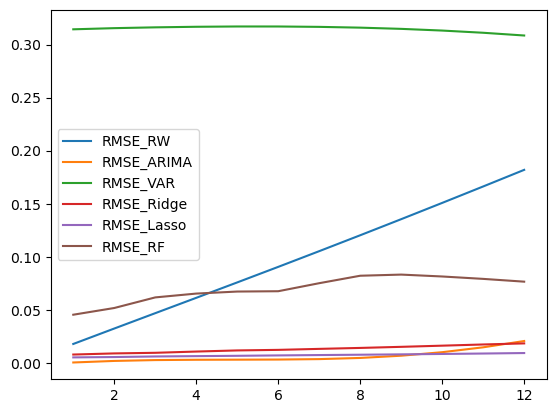

In [34]:
RMSE_2023.plot()

In [35]:
RMSE_2023_results = RMSE_2023.div(RMSE_rw['RMSE_RW'], axis=0)
RMSE_2023_results = RMSE_2023_results.drop(columns=['RMSE_RW'])
RMSE_2023_results_highlight = RMSE_2023_results.style.apply(highlight_min, axis=1)
RMSE_2023_results_highlight

,RMSE_ARIMA,RMSE_VAR,RMSE_Ridge,RMSE_Lasso,RMSE_RF
1,0.021544,17.632814,0.441166,0.290530,2.546159
2,0.056963,9.744169,0.275598,0.170004,1.597659
3,0.056435,6.749576,0.202877,0.129331,1.317162
4,0.047923,5.166413,0.174223,0.103839,1.065328
5,0.039879,4.180646,0.154834,0.087973,0.886522
6,0.034725,3.503640,0.135589,0.077843,0.746375
7,0.033796,3.007476,0.125384,0.070083,0.713251
8,0.038678,2.626684,0.117211,0.063978,0.682855
9,0.049949,2.324178,0.111675,0.059345,0.614354
10,0.066826,2.077256,0.107637,0.055739,0.540066


In [36]:
MAPE_2023_results = MAPE_2023.div(MAPE_rw['MAPE_RW'], axis=0)
MAPE_2023_results = MAPE_2023_results.drop(columns=['MAPE_RW'])
MAPE_2023_results_highlight = MAPE_2023_results.style.apply(highlight_min, axis=1)
MAPE_2023_results_highlight

,MAPE_ARIMA,MAPE_VAR,MAPE_Ridge,MAPE_Lasso,MAPE_RF
1,0.021544,17.632814,0.441166,0.290530,2.546159
2,0.049816,10.407990,0.293340,0.181540,1.699977
3,0.053288,7.320171,0.219484,0.139865,1.407439
4,0.047435,5.614147,0.187912,0.112692,1.146268
5,0.040359,4.527240,0.166306,0.095314,0.954549
6,0.035558,3.769314,0.145320,0.083949,0.799847
7,0.034546,3.206836,0.133564,0.075153,0.756261
8,0.037936,2.769860,0.124079,0.068151,0.718422
9,0.045907,2.418112,0.117370,0.062745,0.640955
10,0.058448,2.126570,0.112295,0.058460,0.548431


In [37]:
tableC23 = RMSE_rw.join(RMSE_2023_results)
tableC23 = tableC23.rename(columns = {'RMSE_RW': 'Benchmark', 'RMSE_ARIMA': 'ARIMA', 'RMSE_VAR': 'VAR', 'RMSE_Ridge': 'Ridge', 
                            'RMSE_Lasso': 'Lasso', 'RMSE_RF':'RF'})
tableC23.index.name = 'horizon'
tableC23.to_excel("../../../output/3_Regression/c23/c23table_rmse.xlsx")

In [38]:
tableC23 = MAPE_rw.join(MAPE_2023_results)
tableC23 = tableC23.rename(columns = {'MAPE_RW': 'Benchmark', 'MAPE_ARIMA': 'ARIMA', 'MAPE_VAR': 'VAR', 'MAPE_Ridge': 'Ridge', 
                            'MAPE_Lasso': 'Lasso', 'MAPE_RF':'RF'})
tableC23.index.name = 'horizon'
tableC23.to_excel("../../../output/3_Regression/c23/c23table_mape.xlsx")

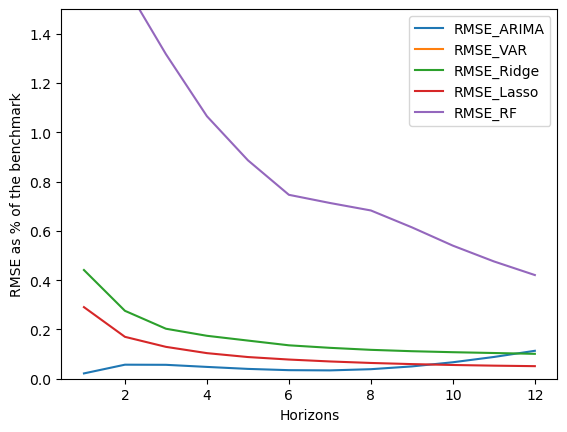

<Figure size 640x480 with 0 Axes>

In [39]:
graph_models(RMSE_2023_results, lim=1.5)

plt.savefig("../../../output/3_Regression/c23/c23_rmse.png", bbox_inches='tight', dpi=300)

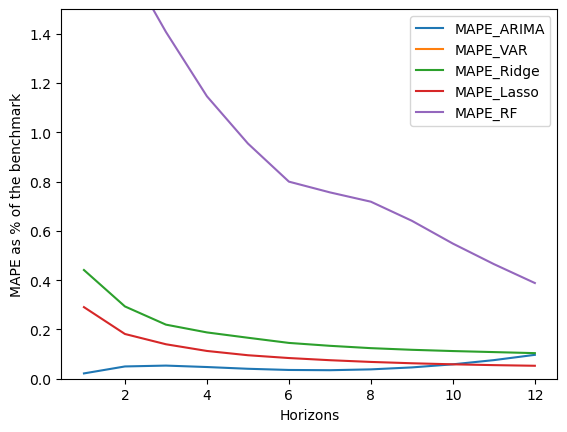

<Figure size 640x480 with 0 Axes>

In [40]:
graph_models(MAPE_2023_results, metric = "MAPE", lim=1.5)

plt.savefig("../../../output/3_Regression/c23/c23_mape.png", bbox_inches='tight', dpi=300)

### 3.3.2 Coefficients by model

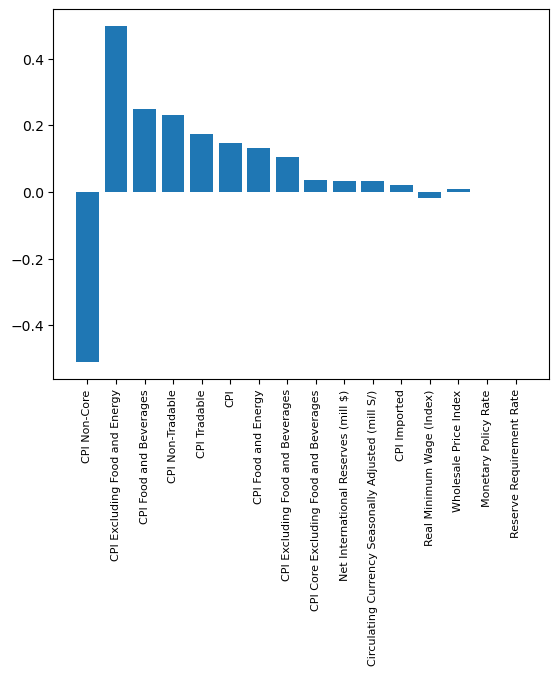

<Figure size 640x480 with 0 Axes>

In [41]:
graph_coefficients(vars_df_ridge, value = "Coefficient")

plt.savefig("../../../output/3_Regression/c23/c23_coef_ridge.png", bbox_inches='tight', dpi=300)

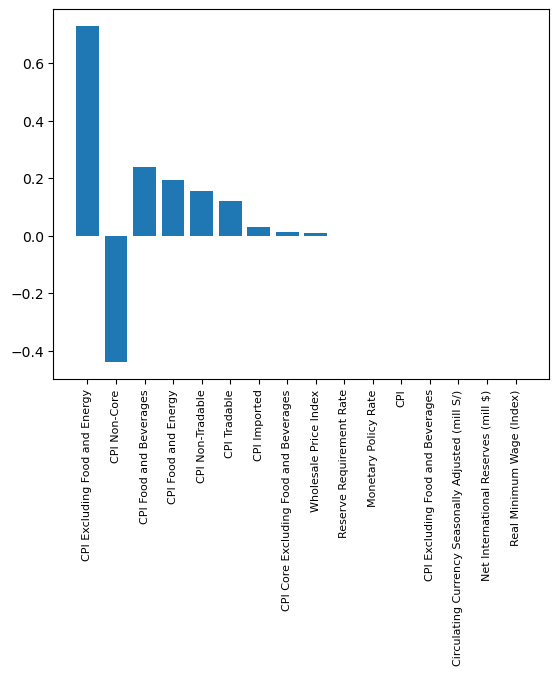

<Figure size 640x480 with 0 Axes>

In [42]:
graph_coefficients(vars_df_lasso, value = "Coefficient")

plt.savefig("../../../output/3_Regression/c23/c23_coef_lasso.png", bbox_inches='tight', dpi=300)

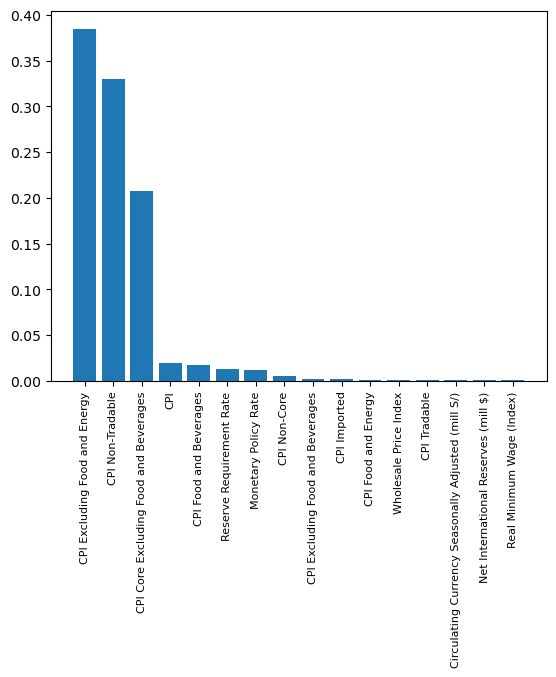

<Figure size 640x480 with 0 Axes>

In [43]:
graph_coefficients(vars_df_rf, value = "Importance Score")

plt.savefig("../../../output/3_Regression/c23/c23_coef_rf.png", bbox_inches='tight', dpi=300)